# Sentiment Model Survey

In [78]:
import json
import pandas as pd
import numpy as np
import itertools
import sys
import re
import string
import nltk
from collections import defaultdict
from sklearn.metrics import classification_report, accuracy_score, f1_score

## Preprocessng and Metrics Functions

In [136]:
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

## clean up strings
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"(.)\1\1+$", r"\1", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

## preprocess punctutation, stop words, stemming
def preprocess_stop_stem(text, punct=True, stem=False, stop=False, sent=False):
    if punct:
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        text = regex.sub('', text)
    tokens = word_tokenize(text) 
    if stop:
        stop = stopwords.words('english')
        tokens =[word for word in tokens if word not in stop]
        tokens = [word.lower() for word in tokens]
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    if sent:
        tokens = ' '.join(tokens)
    return tokens

## preproces a sentence
def preprocess_doc(doc):
    return preprocess_stop_stem(clean_str(doc), punct=True, stem=False, stop=False, sent=True)

## label to sentiment
def create_senti_label(row):
    if row['rating'] >= 3.7:
        label = 'pos'
    elif row['rating'] <= 1.25:
        label = 'neg'
    else:
        label = 'neu'
    return label

## Sentiment score
## convert to sentiment score between 0 - 10
def sentiment_score(score):
    return (score - (-1.0))*5
    
## Labe based on score range of 0 - 10
## If > 7.5: pos
## if < 2.5: neg
## between 2.5 and 7.5 neu
def sentiment_label(score):
    if score >= 7.5:
        return 'pos'
    elif score > 2.5 and score < 7.5:
        return 'neu'
    elif score <= 2.5:
        return 'neg'


## Vader Lexicon (Rule Based Models)

We can use the "rating" the check the accuracy of the sentiment score

In [137]:
reviewData_df = pd.read_csv("product_reviews.csv")
reviewData_df.head()

,modelId,rating,ratingDate,review,reviewId
0,4002178_M,3,08/15/2017,too small It was the second pair of this model...,92123050.0
1,4002178_M,5,07/10/2017,I used to love the Adios 2.0 and tried these ...,89969398.0
2,4002178_M,2,07/08/2017,Too tight around the toes. The most uncomfort...,89918548.0
3,4002178_M,5,06/22/2017,"Really quick and light, it's like you aren't w...",89061405.0
4,4002178_M,2,05/23/2017,"Unhappy Not happy at all, definitely half a si...",86923123.0


In [138]:
reviewData_df['review'] = reviewData_df['review'].apply(preprocess_doc)
reviewData_df['rate_label'] = reviewData_df.apply(create_senti_label, axis = 1)
reviewData_df.head()

,modelId,rating,ratingDate,review,reviewId,rate_label
0,4002178_M,3,08/15/2017,too small it was the second pair of this model...,92123050.0,neu
1,4002178_M,5,07/10/2017,i used to love the adios 2 0 and tried these a...,89969398.0,pos
2,4002178_M,2,07/08/2017,too tight around the toes the most uncomfortab...,89918548.0,neu
3,4002178_M,5,06/22/2017,really quick and light it s like you arent wea...,89061405.0,pos
4,4002178_M,2,05/23/2017,unhappy not happy at all definitely half a siz...,86923123.0,neu


In [63]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#### Test a few samples

In [7]:
sentences = [
                "The plot was good, but the characters are uncompelling and the dialog is not great.", 
                "A really bad, horrible book.",       
                "At least it isn't a horrible book."
            ]

In [36]:
analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

The plot was good, but the characters are uncompelling and the dialog is not great. {'neg': 0.327, 'neu': 0.579, 'pos': 0.094, 'compound': -0.7042}
A really bad, horrible book.------------------------------------- {'neg': 0.791, 'neu': 0.209, 'pos': 0.0, 'compound': -0.8211}
At least it isn't a horrible book.------------------------------- {'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}


In [37]:
vs = analyzer.polarity_scores('A really bad, horrible book.')

In [124]:
vs.keys()

['neg', 'neu', 'pos', 'compound']

#### Vader sentiment Scoring of all reviews

In [139]:
senti_score = []
neg_score = []
pos_score = []
neu_score = []
senti_label = []
count = 0
for review in reviewData_df.loc[:, 'review']:
    vs = analyzer.polarity_scores(review)
    senti_score.append(sentiment_score(vs['compound']))
    neg_score.append(sentiment_score(vs['neg']))
    pos_score.append(sentiment_score(vs['pos']))
    neu_score.append(sentiment_score(vs['neu']))
    senti_label.append(sentiment_label(sentiment_score(vs['compound'])))

In [140]:
reviewData_df['senti_score'] = senti_score
reviewData_df['senti_label'] = senti_label
reviewData_df['neg_score'] = neg_score
reviewData_df['pos_score'] = pos_score
reviewData_df['neu_score'] = neu_score
reviewData_df.head()

,modelId,rating,ratingDate,review,reviewId,rate_label,senti_score,senti_label,neg_score,pos_score,neu_score
0,4002178_M,3,08/15/2017,too small it was the second pair of this model...,92123050.0,neu,6.0200,neu,5.325,5.400,9.280
1,4002178_M,5,07/10/2017,i used to love the adios 2 0 and tried these a...,89969398.0,pos,8.8445,pos,5.000,6.015,8.985
2,4002178_M,2,07/08/2017,too tight around the toes the most uncomfortab...,89918548.0,neu,2.8045,neu,6.040,5.000,8.960
3,4002178_M,5,06/22/2017,really quick and light it s like you arent wea...,89061405.0,pos,7.2880,neu,5.265,5.415,9.320
4,4002178_M,2,05/23/2017,unhappy not happy at all definitely half a siz...,86923123.0,neu,2.6185,neu,6.135,5.530,8.335


In [141]:
print classification_report(reviewData_df['rate_label'], reviewData_df['senti_label'])

             precision    recall  f1-score   support

        neg       0.39      0.35      0.37       705
        neu       0.23      0.37      0.28      1577
        pos       0.92      0.85      0.88     11513

avg / total       0.81      0.77      0.79     13795



In [142]:
print accuracy_score(reviewData_df['rate_label'], reviewData_df['senti_label'])

0.7670895251902863


** The Vader sentiment does a good job for positive sentiment but does poorly for negtaive and neutrual **

### Aggregation for shoe models

In [143]:
reviewData_df_agg = reviewData_df.groupby('modelId')

In [144]:
reviewData_agg = reviewData_df_agg['rating', 'senti_score', 'neg_score', 'pos_score', 'neu_score'].apply(np.mean)
reviewData_agg.head()

,rating,senti_score,neg_score,pos_score,neu_score
modelId,,,,,
100029,5.000000,8.858500,5.000000,7.865000,7.135000
110196,4.297710,7.505256,5.124924,6.598053,8.276870
110211,4.294118,7.531824,5.256275,6.399412,8.344412
110214,4.434783,8.229783,5.144130,6.432826,8.423043
110215,4.358491,8.188585,5.189009,6.459410,8.351675


In [147]:
senti_label = []
for score in reviewData_agg.loc[:, 'senti_score']:
    senti_label.append(sentiment_label(score))

reviewData_agg['senti_label'] = senti_label
reviewData_agg = reviewData_agg.reset_index()
reviewData_agg.head()

,modelId,rating,senti_score,neg_score,pos_score,neu_score,senti_label
0,100029,5.000000,8.858500,5.000000,7.865000,7.135000,pos
1,110196,4.297710,7.505256,5.124924,6.598053,8.276870,pos
2,110211,4.294118,7.531824,5.256275,6.399412,8.344412,pos
3,110214,4.434783,8.229783,5.144130,6.432826,8.423043,pos
4,110215,4.358491,8.188585,5.189009,6.459410,8.351675,pos


### Create some visual

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py

In [184]:
x = reviewData_agg.loc[0, 'senti_score':'neu_score']
x = pd.DataFrame(x)
x.rename(columns={0:'scores'}, inplace=True)
x = x.transpose()

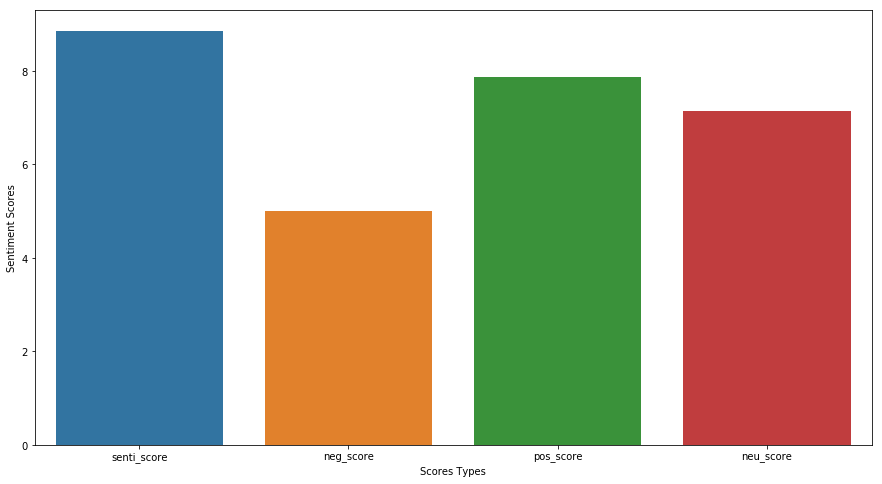

In [185]:
plt.figure(figsize = (15, 8))
ax = sns.barplot(data=x)
ax.set(xlabel = 'Scores Types', ylabel = 'Sentiment Scores')
plt.show()

### Donut plot example

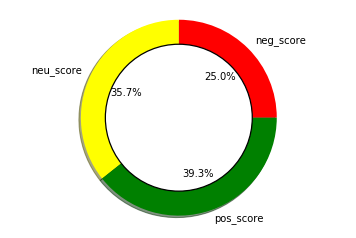

In [188]:
# The slices will be ordered and plotted counter-clockwise.
labels = 'neg_score', 'neu_score', 'pos_score'
sizes = [x['neg_score'], x['neu_score'], x['pos_score']]
colors = ['red', 'yellow', 'green']
explode = (0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  


## Text blob (Pattern based Model)

Reload data

In [50]:
reviewData_df = pd.read_csv("product_reviews.csv")
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId
0,4,08/15/2017,beautifullllllllllllllllllllllllllllllllllllll...,NaN,4002178_W
1,1,05/08/2017,The actual product came out looking much diffe...,Disappointing,4002178_W
2,1,04/10/2017,These shoes look nothing like the picture! I e...,NaN,4002178_W
3,1,02/26/2017,I ordered this shoe because i loved the displa...,color sample was way off,4002178_W
4,5,09/15/2017,They are comfortable sneakers for working out ...,awesome sneakers,4002179_W


In [51]:
reviewData_df['reviewComments'] = reviewData_df['reviewComments'].apply(preprocess_doc)
reviewData_df['label'] = reviewData_df.apply(create_senti_label, axis = 1)
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId,label
0,4,08/15/2017,beautiful,NaN,4002178_W,pos
1,1,05/08/2017,actual product came looking much different onl...,Disappointing,4002178_W,neg
2,1,04/10/2017,shoes look nothing like picture expected grey ...,NaN,4002178_W,neg
3,1,02/26/2017,ordered shoe loved displayed blush pink color ...,color sample was way off,4002178_W,neg
4,5,09/15/2017,comfortable sneakers working running,awesome sneakers,4002179_W,pos


In [52]:
from textblob import TextBlob

#### Test a few samples

In [53]:
sentences = [
                "The plot was good, but the characters are uncompelling and the dialog is not great.", 
                "A really bad, horrible book.",       
                "At least it isn't a horrible book."
            ]

In [54]:
for sentence in sentences:
    testimonial = TextBlob(sentence)
    print testimonial.sentiment

Sentiment(polarity=0.14999999999999997, subjectivity=0.675)
Sentiment(polarity=-0.8499999999999999, subjectivity=0.8333333333333333)
Sentiment(polarity=-0.65, subjectivity=0.7)


In [55]:
senti_score = []
count = 0
for review in reviewData_df.loc[:, 'reviewComments']:
    testimonial = TextBlob(review)
    senti_score.append(sentiment_result(testimonial.sentiment.polarity))

In [56]:
reviewData_df['sentiment'] = senti_score
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId,label,sentiment
0,4,08/15/2017,beautiful,NaN,4002178_W,pos,pos
1,1,05/08/2017,actual product came looking much different onl...,Disappointing,4002178_W,neg,neu
2,1,04/10/2017,shoes look nothing like picture expected grey ...,NaN,4002178_W,neg,neu
3,1,02/26/2017,ordered shoe loved displayed blush pink color ...,color sample was way off,4002178_W,neg,neu
4,5,09/15/2017,comfortable sneakers working running,awesome sneakers,4002179_W,pos,neu


In [57]:
print classification_report(reviewData_df['label'], reviewData_df['sentiment'])

             precision    recall  f1-score   support

        neg       0.40      0.04      0.07       146
        neu       0.11      0.92      0.20       365
        pos       0.97      0.32      0.48      3777

avg / total       0.88      0.36      0.44      4288



** The textblob sentiment did worse than Vader, especially in negative and neural reviews**

## Pattern Model

Reload data

In [63]:
reviewData_df = pd.read_csv("product_reviews.csv")
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId
0,4,08/15/2017,beautifullllllllllllllllllllllllllllllllllllll...,NaN,4002178_W
1,1,05/08/2017,The actual product came out looking much diffe...,Disappointing,4002178_W
2,1,04/10/2017,These shoes look nothing like the picture! I e...,NaN,4002178_W
3,1,02/26/2017,I ordered this shoe because i loved the displa...,color sample was way off,4002178_W
4,5,09/15/2017,They are comfortable sneakers for working out ...,awesome sneakers,4002179_W


In [64]:
reviewData_df['reviewComments'] = reviewData_df['reviewComments'].apply(preprocess_doc)
reviewData_df['label'] = reviewData_df.apply(create_senti_label, axis = 1)
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId,label
0,4,08/15/2017,beautiful,NaN,4002178_W,pos
1,1,05/08/2017,actual product came looking much different onl...,Disappointing,4002178_W,neg
2,1,04/10/2017,shoes look nothing like picture expected grey ...,NaN,4002178_W,neg
3,1,02/26/2017,ordered shoe loved displayed blush pink color ...,color sample was way off,4002178_W,neg
4,5,09/15/2017,comfortable sneakers working running,awesome sneakers,4002179_W,pos


In [65]:
from pattern.en import sentiment

In [66]:
sentences = [
                "The plot was good, but the characters are uncompelling and the dialog is not great.", 
                "A really bad, horrible book.",       
                "At least it isn't a horrible book."
            ]

In [67]:
for sentence in sentences:
    pattern_senti = sentiment(sentence)
    print pattern_senti

(0.14999999999999997, 0.675)
(-0.8499999999999999, 0.8333333333333333)
(0.1, 0.7)


In [68]:
senti_score = []
count = 0
for review in reviewData_df.loc[:, 'reviewComments']:
    pattern_senti = sentiment(review)
    senti_score.append(sentiment_result(pattern_senti[0]))

In [69]:
reviewData_df['sentiment'] = senti_score
reviewData_df.head()

,rating,ratingDate,reviewComments,reviewTitle,modelId,label,sentiment
0,4,08/15/2017,beautiful,NaN,4002178_W,pos,pos
1,1,05/08/2017,actual product came looking much different onl...,Disappointing,4002178_W,neg,neu
2,1,04/10/2017,shoes look nothing like picture expected grey ...,NaN,4002178_W,neg,neu
3,1,02/26/2017,ordered shoe loved displayed blush pink color ...,color sample was way off,4002178_W,neg,neu
4,5,09/15/2017,comfortable sneakers working running,awesome sneakers,4002179_W,pos,neu


In [70]:
print classification_report(reviewData_df['label'], reviewData_df['sentiment'])

             precision    recall  f1-score   support

        neg       0.40      0.04      0.07       146
        neu       0.11      0.92      0.20       365
        pos       0.97      0.32      0.48      3777

avg / total       0.88      0.36      0.44      4288



## Additional Resource

https://github.com/laugustyniak/awesome-sentiment-analysis

### Options:

* Use APIs: There are many APIs to use but they are not free.
* Train a sentiment model ideal choice but it will take time.